**Imports:**

In [1]:
import os
import zipfile

**Extraction of the Data from the zip (run only one time):**

In [2]:
zip_path = "./data/archive.zip"
extract_dir = "./data/rps_data"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print("✓ Downloaded and extracted into:", os.path.abspath(extract_dir))

✓ Downloaded and extracted into: c:\Users\nrsaa\startup\git-repos\Image-Classification-with-CNNs\data\rps_data


**Trainin the DATA:**

In [2]:
# Data loading: create tf.data datasets from the extracted images
try:
    import tensorflow as tf
    from tensorflow.keras.utils import image_dataset_from_directory
    data_dir = './data/rps_data'
    if not os.path.exists(data_dir):
        print('Data directory not found at', data_dir)
    else:
    
        train_ds = image_dataset_from_directory(data_dir, validation_split=0.2, subset='training', seed=123, image_size=(150,150), batch_size=32) 
        val_ds = image_dataset_from_directory(data_dir, validation_split=0.2, subset='validation', seed=123, image_size=(150,150), batch_size=32) 
        class_names = train_ds.class_names
        print('Classes:', class_names)
        for images, labels in train_ds.take(1):
            print('Batch shape:', images.shape, 'Labels shape:', labels.shape)
except Exception as e:
    print('Could not create tf datasets:', e)

Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.
Classes: ['paper', 'rock', 'scissors']
Batch shape: (32, 150, 150, 3) Labels shape: (32,)


**Training & Evaluation (CNN):** 
Compact CNN trained with Adam, saves best model, evaluates on validation set, and displays a few misclassified examples.

Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.
Classes: ['paper', 'rock', 'scissors']
Batch shape: (32, 150, 150, 3) Labels shape: (32,)
Training config: RUN_FULL_TRAIN=True, EARLY_STOPPING_PATIENCE=5, NUM_EPOCHS=30
Callbacks: ['ModelCheckpoint']
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 509ms/step - accuracy: 0.6745 - loss: 0.7356 - val_accuracy: 0.9085 - val_loss: 0.2588
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 506ms/step - accuracy: 0.9103 - loss: 0.2417 - val_accuracy: 0.9405 - val_loss: 0.1773
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 495ms/step - accuracy: 0.9395 - loss: 0.1590 - val_accuracy: 0.9657 - val_loss: 0.1098
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 501ms/step - accuracy: 0.9543 - loss: 0.1317 - val_accuracy: 0.9657 - val_loss: 0.0950
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 483ms/step - accuracy: 0.9772 - loss: 0.0681 - val_accuracy: 0.9703 - val_loss: 0.1046
Epoch 6/30

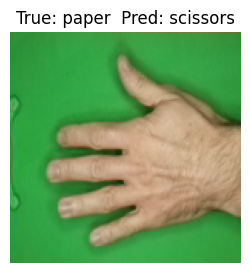

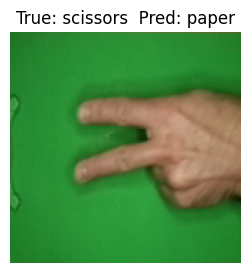

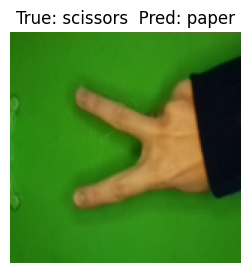

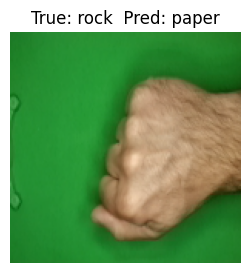

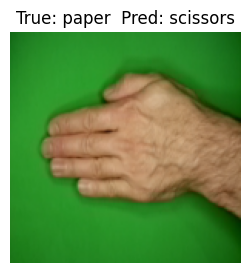

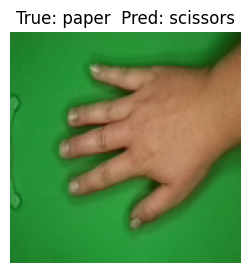


Possible reasons for confusion: small inter-class variations, similar hand poses, different lighting/backgrounds, or low image resolution.


In [ ]:
RUN_FULL_TRAIN = True 
EARLY_STOPPING_PATIENCE = 5 
NUM_EPOCHS = 30  
try:  
    import tensorflow as tf 
    from tensorflow.keras.utils import image_dataset_from_directory  
    data_dir = './data/rps_data' 
    if not os.path.exists(data_dir): 
        print('Data directory not found at', data_dir) 
    else:
        train_ds = image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset='training',
            seed=123,
            image_size=(150, 150),
            batch_size=32,
        ) 
        val_ds = image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset='validation',
            seed=123,
            image_size=(150, 150),
            batch_size=32,
        ) 
        class_names = train_ds.class_names 
        print('Classes:', class_names) 
        for images, labels in train_ds.take(1): 
            print('Batch shape:', images.shape, 'Labels shape:', labels.shape) 
       
        try:
            
            AUTOTUNE = tf.data.AUTOTUNE
            train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
            val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

            
            model = tf.keras.Sequential([
                tf.keras.layers.Rescaling(1./255, input_shape=(150,150,3)),  
                tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(3, activation='softmax') 
            ])

           
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

           
            callbacks = [
                tf.keras.callbacks.ModelCheckpoint('best_rps_model.keras', save_best_only=True, monitor='val_loss'),
            ]
            if not RUN_FULL_TRAIN:
                callbacks.append(
                    tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=EARLY_STOPPING_PATIENCE,
                        restore_best_weights=True
                    )
                )
          
            print(f"Training config: RUN_FULL_TRAIN={RUN_FULL_TRAIN}, EARLY_STOPPING_PATIENCE={EARLY_STOPPING_PATIENCE}, NUM_EPOCHS={NUM_EPOCHS}")
         
            print('Callbacks:', [type(cb).__name__ for cb in callbacks])

            history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=callbacks)

            model.save('rps_cnn_final.keras')

            test_loss, test_acc = model.evaluate(val_ds)
            print('Final test accuracy:', test_acc)

            import numpy as np
            import matplotlib.pyplot as plt

            val_images = np.concatenate([x.numpy() for x, y in val_ds], axis=0)
            val_labels = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

            preds = model.predict(val_images)
            pred_labels = np.argmax(preds, axis=1)

            mis_idx = np.where(pred_labels != val_labels)[0]
            print('Number of misclassified examples in validation set:', len(mis_idx))

            n_show = min(6, len(mis_idx))
            for i in range(n_show):
                idx = mis_idx[i]
                plt.figure(figsize=(3,3))
                plt.imshow(val_images[idx].astype('uint8'))
                plt.title(f"True: {class_names[pred_labels[idx]]}  Pred: {class_names[val_labels[idx]]}")
                plt.axis('off')
                plt.show()
        except Exception as e:
            print('Model build/train/eval skipped or failed:', e)
except Exception as e:
    print('Could not create tf datasets:', e) 